In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import seaborn as sns
import json


In [6]:
def load_pred_df(url: str, sep='\t') -> pd.DataFrame:
    df = pd.read_csv(url, sep=sep)
    df = df.transpose() 

    # cleanup
    df.columns = df.iloc[0, :]
    df = df.drop(['Unnamed: 0'])

    return df

In [7]:
def attach_metadata(df, y):
    pass

In [8]:
counts_df = load_pred_df("data/gse68086/GSE68086_TEP_data_matrix.txt/GSE68086_TEP_data_matrix.txt")
counts_df = counts_df.astype('int')
counts_df.shape

(285, 57736)

# Prep Metadata

Clean up metadata columns and values. Main filtering:
- making column names uniform by replacing spaces with _, removing special characters, and making column names lowercase
- removed extract "" from metadata values

In [9]:
meta_data = pd.read_csv("data/gse68086/GSE68086_series_matrix.csv")
meta_data.columns = meta_data.columns.str.strip('!').str.lower().str.replace('.', '_')
meta_data.head()

,sample_geo_accession,sample_status,sample_submission_date,sample_last_update_date,sample_type,sample_channel_count,sample_source_name_ch1,sample_organism_ch1,sample_characteristics_ch1,sample_characteristics_ch1_1,...,sample_instrument_model,sample_library_selection,sample_library_source,sample_library_strategy,sample_relation,sample_relation_1,sample_supplementary_file_1,series_matrix_table_begin,"""id_ref""",series_matrix_table_end
0,"""GSM1662534""","""Public on Oct 30 2015""","""Apr 21 2015""","""May 15 2019""","""SRA""","""1""","""3-Breast-Her2-ampl""","""Homo sapiens""","""tissue: blood""","""cell type: Thrombocytes""",...,"""Illumina HiSeq 2500""","""cDNA""","""transcriptomic""","""RNA-Seq""","""BioSample: https://www.ncbi.nlm.nih.gov/biosa...","""SRA: https://www.ncbi.nlm.nih.gov/sra?term=SR...","""NONE""",NaN,"""GSM1662534""",NaN
1,"""GSM1662535""","""Public on Oct 30 2015""","""Apr 21 2015""","""May 15 2019""","""SRA""","""1""","""8-Breast-WT""","""Homo sapiens""","""tissue: blood""","""cell type: Thrombocytes""",...,"""Illumina HiSeq 2500""","""cDNA""","""transcriptomic""","""RNA-Seq""","""BioSample: https://www.ncbi.nlm.nih.gov/biosa...","""SRA: https://www.ncbi.nlm.nih.gov/sra?term=SR...","""NONE""",NaN,"""GSM1662535""",NaN
2,"""GSM1662536""","""Public on Oct 30 2015""","""Apr 21 2015""","""May 15 2019""","""SRA""","""1""","""10-Breast-Her2-ampl""","""Homo sapiens""","""tissue: blood""","""cell type: Thrombocytes""",...,"""Illumina HiSeq 2500""","""cDNA""","""transcriptomic""","""RNA-Seq""","""BioSample: https://www.ncbi.nlm.nih.gov/biosa...","""SRA: https://www.ncbi.nlm.nih.gov/sra?term=SR...","""NONE""",NaN,"""GSM1662536""",NaN
3,"""GSM1662537""","""Public on Oct 30 2015""","""Apr 21 2015""","""May 15 2019""","""SRA""","""1""","""Breast-100""","""Homo sapiens""","""tissue: blood""","""cell type: Thrombocytes""",...,"""Illumina HiSeq 2500""","""cDNA""","""transcriptomic""","""RNA-Seq""","""BioSample: https://www.ncbi.nlm.nih.gov/biosa...","""SRA: https://www.ncbi.nlm.nih.gov/sra?term=SR...","""NONE""",NaN,"""GSM1662537""",NaN
4,"""GSM1662538""","""Public on Oct 30 2015""","""Apr 21 2015""","""May 15 2019""","""SRA""","""1""","""15-Breast-Her2-ampl""","""Homo sapiens""","""tissue: blood""","""cell type: Thrombocytes""",...,"""Illumina HiSeq 2500""","""cDNA""","""transcriptomic""","""RNA-Seq""","""BioSample: https://www.ncbi.nlm.nih.gov/biosa...","""SRA: https://www.ncbi.nlm.nih.gov/sra?term=SR...","""NONE""",NaN,"""GSM1662538""",NaN


In [10]:
# clean up the metadata of double-quotes
obj_cols = list(meta_data.columns[meta_data.dtypes == "object"])

for col in obj_cols:
    meta_data[col] = meta_data[col].str.strip('"')

In [11]:
meta_data['target'] = meta_data['sample_characteristics_ch1_3'].apply(lambda x: 1 if x == 'cancer type: HC' else 0)

In [12]:
meta_data.sample_source_name_ch1.value_counts()

sample_source_name_ch1
3-Breast-Her2-ampl     1
Lung-0017              1
VU271-CRC              1
Lung-0026J             1
Lung-0025J             1
                      ..
VU456-1-GBM-WT         1
VU468-1-GBM-WT         1
GBM-471                1
GBM-475                1
MGH-NSCLC-L65-TR523    1
Name: count, Length: 285, dtype: int64

In [13]:
# save this metadata for later
target_meta = meta_data.loc[:, ['sample_source_name_ch1', 'target']]

In [14]:
# the key columns with metadata
meta_data[['sample_characteristics_ch1_1', 'sample_characteristics_ch1_2', 'sample_characteristics_ch1_3', 'sample_characteristics_ch1_4', 'sample_characteristics_ch1_5']].head()

,sample_characteristics_ch1_1,sample_characteristics_ch1_2,sample_characteristics_ch1_3,sample_characteristics_ch1_4,sample_characteristics_ch1_5
0,cell type: Thrombocytes,patient id: Breast-03,cancer type: Breast,batch: Batch03,mutational subclass: HER2+
1,cell type: Thrombocytes,patient id: Breast-08,cancer type: Breast,batch: Batch03,mutational subclass: wt
2,cell type: Thrombocytes,patient id: Breast-10,cancer type: Breast,batch: Batch03,mutational subclass: HER2+
3,cell type: Thrombocytes,patient id: Breast-100,cancer type: Breast,batch: Batch04,mutational subclass: Triple Negative
4,cell type: Thrombocytes,patient id: Breast-15,cancer type: Breast,batch: Batch03,mutational subclass: HER2+


# Filtering of gene expression data

Due to RNASeq being sparse, it is imperative to remove features which show little to no expression. A common threshold used when processing RNASeq data is to remove gene expression where there are less then 10 transcripts expressed per gene across all of the samples.

In [15]:
# check for any NAs. As the dataframe possesses ~ 18,000 features I use a repeated sum to show there are no NA values across all features
counts_df.isna().sum().sum()

np.int64(0)

In [16]:
# calculate the column sum (feature sum/ gene_sum)
colsums = pd.Series(counts_df.sum(axis=0))

# if colsum >= 10, keep else remove
counts_df = counts_df.loc[:, colsums.values >= 10]
counts_df.shape

(285, 18013)

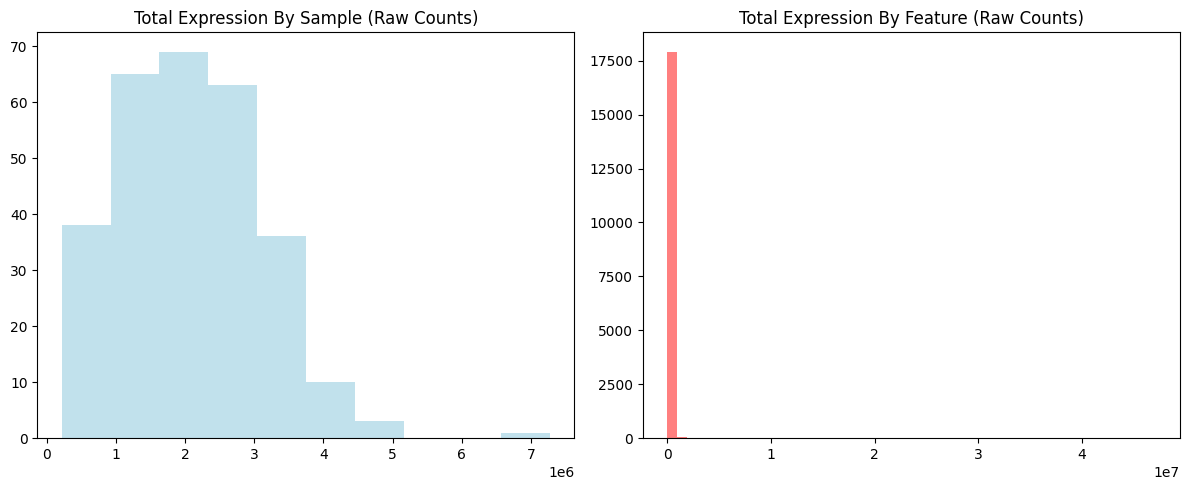

In [17]:
# total expression across samples
left_data = counts_df.sum(axis=1)
# total expression by feature
right_data = counts_df.sum(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# left plot
axes[0].hist(left_data, alpha=0.75, color='lightblue')
axes[0].set_title('Total Expression By Sample (Raw Counts)')

axes[1].hist(right_data, bins=50, alpha=0.5, color='red')
axes[1].set_title('Total Expression By Feature (Raw Counts)')

plt.tight_layout()
plt.show()

Based on the above graph, transformation of the data seems absolutely necessary. After transforming the data, any genes/samples which are strong outliers will be removed.

In [18]:
# perform the transformation
norm_df = np.log2(counts_df + 1)

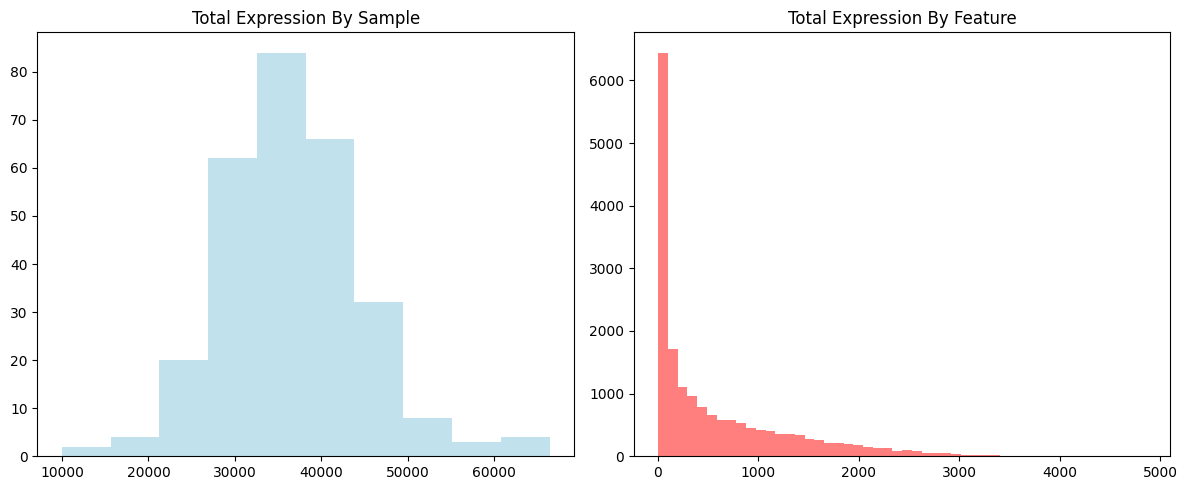

In [19]:
# regraph to see if the outlier is removed
#total expression across samples
left_data = norm_df.sum(axis=1)
# total expression by feature
right_data = norm_df.sum(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# left plot
axes[0].hist(left_data, alpha=0.75, color='lightblue')
axes[0].set_title('Total Expression By Sample')

axes[1].hist(right_data, bins=50, alpha=0.5, color='red')
axes[1].set_title('Total Expression By Feature')

plt.tight_layout()
plt.show()

Based on the results of the log-transformation no further filtering of either samples or genes is necessary. Total transcripts by sample is approximately normal while expression per gene has the long-right skewed tailed which is typical of RNASeq data. 

For tree-based models, normalizing the gene expression is not needed, however for logistic regression, it might be beneficial.

# Attach metadata to counts and train, val, split the samples

In [20]:
# perform a join on the data values
df = pd.merge(left=target_meta, right=counts_df, how="left", left_on='sample_source_name_ch1', right_on=counts_df.index)
df.head()

,sample_source_name_ch1,target,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,ENSG00000273355,ENSG00000273356,ENSG00000273362,ENSG00000273388,ENSG00000273415,ENSG00000273437,ENSG00000273445,ENSG00000273456,ENSG00000273486,ENSG00000273492
0,3-Breast-Her2-ampl,0,0,44,26,81,171,34,83,0,...,0,3,0,0,0,0,0,0,1,4
1,8-Breast-WT,0,0,14,1,98,99,0,107,0,...,0,0,0,0,0,0,0,0,0,0
2,10-Breast-Her2-ampl,0,0,16,14,18,25,0,62,4,...,0,0,0,0,0,0,0,0,0,0
3,Breast-100,0,0,8,0,17,4,0,19,0,...,0,0,0,0,0,0,0,0,0,0
4,15-Breast-Her2-ampl,0,17,9,4,0,49,0,40,0,...,0,0,0,0,0,0,0,0,0,0


# Prep Data for Training

In [21]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, stratify=df.target.values,  shuffle=True, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, stratify=df_full_train.target, shuffle=True, random_state=1)

In [22]:
# check the dimensions of the dataset
df_train.target.value_counts()
df_val.target.value_counts()
df_test.target.value_counts()

target
0    46
1    11
Name: count, dtype: int64

In [23]:
# create the response
y_train = df_train.target.astype(int).values
y_val = df_val.target.astype(int).values
y_test = df_test.target.astype(int).values

In [24]:
y_train

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [25]:
# delete the response from the dataframe along with sample_source_name_ch1d
del df_train['sample_source_name_ch1']
del df_train['target']

del df_val['sample_source_name_ch1']
del df_val['target']

del df_test['sample_source_name_ch1']
del df_test['target']

In [26]:
# convert to dictionaries
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

In [27]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

# Dummy Classifier
- This gives us a baseline for our model. As the RNAseq dataset is currently unbalanced with cancerous samples outnumbering healthy samples including a dummy classifier is essential to have a baseline of model performance. 

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# compute the baseline performance for dummy classifier
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='most_frequent', random_state=1)
dc.fit(X_train, y_train)
y_dummy = dc.predict_proba(X_val)[:, 1]

# performance
print("AUC score: ", roc_auc_score(y_val, y_dummy))
print(f"Accuracy score: ", accuracy_score(y_val, y_dummy))

AUC score:  0.5
Accuracy score:  0.8070175438596491


# Decision Tree Classifier

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text, export_graphviz, export_text

dt = DecisionTreeClassifier(criterion='entropy', random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]


# see performance on roc_auc
print("AUC score: ", roc_auc_score(y_val, y_pred))
print(f"Accuracy score: ", accuracy_score(y_val, y_pred))

AUC score:  0.8092885375494071
Accuracy score:  0.8596491228070176


In [30]:
dot_data = export_graphviz(
    dt,
    out_file=None,  # Don't save to file, return string
    feature_names=dv.get_feature_names_out(),  # or list of feature names
    class_names=['0', '1'],  # your class labels
    filled=True,  # Color nodes by class
    rounded=True,  # Rounded node boxes
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.view()

'Source.gv.pdf'

Result of the graphviz

<img src="images-midterm/Screenshot 2025-11-18 at 11.31.20 PM.png">

### Hyper Parameter Tuning for Decision Trees

- tune the max_depth: `[3, 4, 5, 6, 7, 8, 9, 10]`
- tune min_samples_leaf: `[1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30]`

In [31]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ENSG00000155657 <= 33.50
|   |--- ENSG00000130811 <= 217.50
|   |   |--- ENSG00000213199 <= 0.50
|   |   |   |--- class: 0
|   |   |--- ENSG00000213199 >  0.50
|   |   |   |--- ENSG00000107341 <= 36.00
|   |   |   |   |--- class: 1
|   |   |   |--- ENSG00000107341 >  36.00
|   |   |   |   |--- class: 0
|   |--- ENSG00000130811 >  217.50
|   |   |--- class: 1
|--- ENSG00000155657 >  33.50
|   |--- ENSG00000172893 <= 11.00
|   |   |--- class: 1
|   |--- ENSG00000172893 >  11.00
|   |   |--- ENSG00000246662 <= 0.50
|   |   |   |--- ENSG00000125148 <= 13.50
|   |   |   |   |--- class: 1
|   |   |   |--- ENSG00000125148 >  13.50
|   |   |   |   |--- class: 0
|   |   |--- ENSG00000246662 >  0.50
|   |   |   |--- class: 1



In [32]:
max_depth_auc_scores = {}

for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    dt = DecisionTreeClassifier(max_depth=d, criterion='entropy', random_state=1)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    max_depth_auc_scores[d] = auc

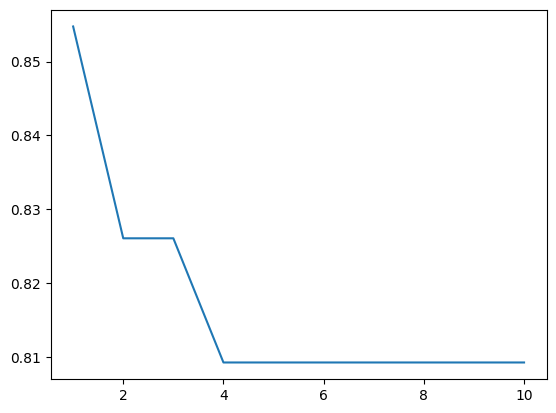

In [33]:
plt.plot(max_depth_auc_scores.keys(), max_depth_auc_scores.values())    

The above graph shows that max_depth reaches the highest auc_score when the graph has a max_depth of 1. This indicates that splitting the tree on a single gene/ensembl transcript provides the best performance.

In [34]:
min_samples_auc_scores = []

for d in [1, 2, 3, 4, 5, 6]:
    for s in [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30]:
        dt = DecisionTreeClassifier(max_depth=d, criterion='entropy', random_state=1)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        min_samples_auc_scores.append((d, s, auc))

<Axes: xlabel='max_depth', ylabel='min_samples'>

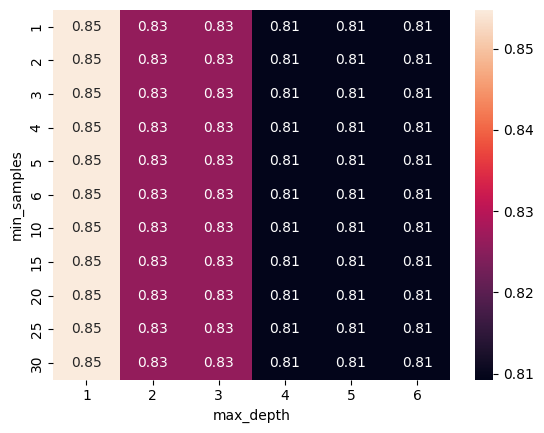

In [35]:
d_s_auc_df = pd.DataFrame(min_samples_auc_scores, columns=['max_depth', 'min_samples', 'auc'])
scores_pivoted = d_s_auc_df.pivot(columns='max_depth', index='min_samples', values='auc')

sns.heatmap(scores_pivoted, annot=True)

The above heatmap matches the graph above showing that a max_depth of 1 gives the best tree based model performance. Moreover, min_samples_leaf parameter has not impact on auc score according to the heatmap. Transcipt `ENSG00000155657` known as Titin (TTN) gene shows that when expression is low (specifically, less then 33.2 ~ 2^33.2) that most samples can be called as cancer.

However, this may be a batch artifact attributable to sample preparation rather then actual biological signal.

In [36]:
# compute final model performance based on hyper parameter tuning
dt = DecisionTreeClassifier(max_depth=1, min_samples_leaf=6, criterion='entropy', random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_test)[:, 1]
print("DT auc: ", roc_auc_score(y_test, y_pred))

DT auc:  0.900197628458498


# Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]


# see performance on roc_auc
print("RF AUC score: ", roc_auc_score(y_val, y_pred))

# get accuracy into a workable form
y_pred = (y_pred >= 0.5).astype(int)
print(f"RF Accuracy score: ", accuracy_score(y_val, y_pred))

RF AUC score:  0.9071146245059288
RF Accuracy score:  0.8947368421052632


# Hyperparameter tuning
- n_estimators: is the number of trees created for the consensus classification. n=10 makes 10 trees then takes their average
- max_parameters


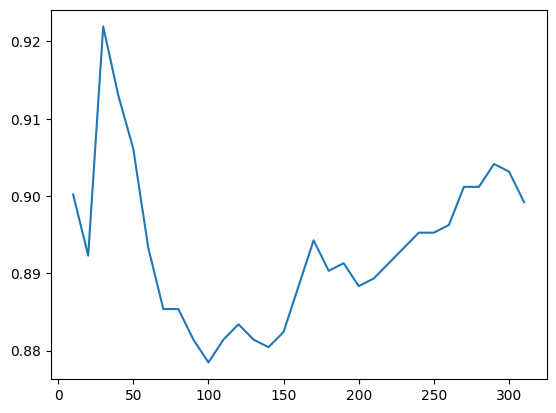

In [38]:
n_estimators_scores = {}

for n in range(10, 311, 10):
    rf = RandomForestClassifier(n_estimators=n, criterion='entropy', random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    n_estimators_scores[n] = auc

plt.plot(n_estimators_scores.keys(), n_estimators_scores.values())

In [39]:
n_estimators_scores

{10: 0.900197628458498,
 20: 0.8922924901185771,
 30: 0.9219367588932806,
 40: 0.9130434782608696,
 50: 0.9061264822134388,
 60: 0.8932806324110673,
 70: 0.8853754940711464,
 80: 0.8853754940711462,
 90: 0.8814229249011858,
 100: 0.8784584980237155,
 110: 0.8814229249011859,
 120: 0.883399209486166,
 130: 0.8814229249011859,
 140: 0.8804347826086957,
 150: 0.8824110671936759,
 160: 0.8883399209486167,
 170: 0.8942687747035574,
 180: 0.8903162055335968,
 190: 0.891304347826087,
 200: 0.8883399209486166,
 210: 0.8893280632411068,
 220: 0.8913043478260869,
 230: 0.8932806324110673,
 240: 0.8952569169960475,
 250: 0.8952569169960474,
 260: 0.8962450592885376,
 270: 0.9011857707509883,
 280: 0.9011857707509882,
 290: 0.9041501976284585,
 300: 0.9031620553359685,
 310: 0.8992094861660079}

Based on the initial run of n_estimators it appears that lower number of trees gives better results. Next is to tighten up this parameter to include a stepsize of 2 for values from 10 to 40

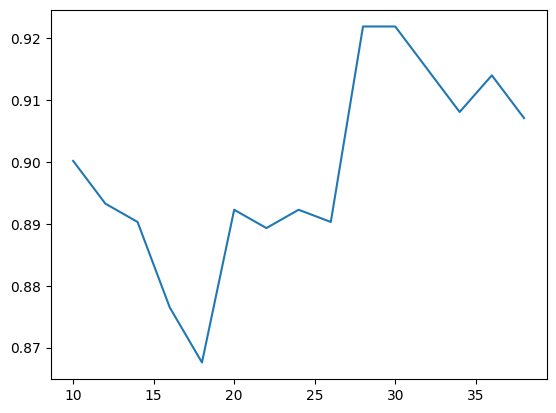

In [40]:
n_estimators_10_40_scores = {}

for n in range(10, 40, 2):
    rf = RandomForestClassifier(n_estimators=n, criterion='entropy', random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    n_estimators_10_40_scores[n] = auc

plt.plot(n_estimators_10_40_scores.keys(), n_estimators_10_40_scores.values())

In [41]:
n_estimators_10_40_scores

{10: 0.900197628458498,
 12: 0.8932806324110673,
 14: 0.8903162055335969,
 16: 0.8764822134387351,
 18: 0.8675889328063241,
 20: 0.8922924901185771,
 22: 0.8893280632411067,
 24: 0.8922924901185771,
 26: 0.8903162055335969,
 28: 0.9219367588932806,
 30: 0.9219367588932806,
 32: 0.9150197628458498,
 34: 0.908102766798419,
 36: 0.9140316205533596,
 38: 0.9071146245059288}

Based on the above two graphs, the optimal parameter appears to be in the range 28 to 30. Now we tune the the max_depth for the decision tree.

In [42]:
rf_d_n_scores = []

for d in range(1, 24, 2):
    for n in [25, 28, 29, 30, 32, 35]:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, criterion='entropy', random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        rf_d_n_scores.append((d, n, auc))        

In [43]:
rf_d_n_scores_df = pd.DataFrame(rf_d_n_scores, columns=['max_depth', 'n_est', 'auc'])
rf_d_n_scores_pivot = rf_d_n_scores_df.pivot(columns='n_est', index='max_depth', values='auc')
rf_d_n_scores_pivot

n_est,25,28,29,30,32,35
max_depth,,,,,,
1,0.871542,0.889328,0.893281,0.903162,0.897233,0.901186
3,0.859684,0.903162,0.901186,0.907115,0.901186,0.924901
5,0.890316,0.917984,0.916008,0.918972,0.912055,0.911067
7,0.892292,0.921937,0.919960,0.921937,0.915020,0.910079
9,0.892292,0.921937,0.919960,0.921937,0.915020,0.910079
11,0.892292,0.921937,0.919960,0.921937,0.915020,0.910079
13,0.892292,0.921937,0.919960,0.921937,0.915020,0.910079
15,0.892292,0.921937,0.919960,0.921937,0.915020,0.910079
17,0.892292,0.921937,0.919960,0.921937,0.915020,0.910079


<Axes: xlabel='n_est', ylabel='max_depth'>

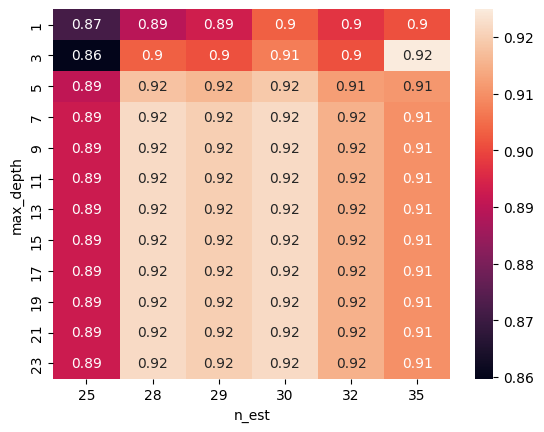

In [44]:
sns.heatmap(rf_d_n_scores_pivot, annot=True)

Based on the above graph, it appears that having N_estimators~30, and a max_depth that is greater than 7 provides the best model performance. 

In [45]:
# train final model with optimized hyperparameters
rf = RandomForestClassifier(n_estimators=30, max_depth=7, criterion='entropy', random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print("Random Forest auc: ", auc)

Random Forest auc:  0.9683794466403162


Based on the high accuracy of this model, I assume that the Random Forest may be classifying the cells properly, but this may be due to batch effects the healthy dataset rather then true biological signal. Adding more healthy cells from different batches would probably lead to degraded performance.

However, according to the original manuscript, they state that they could distinguish non-cancer from cancer cells with 96% accuracy. The classifier developed here supports the original papers claim, however, I am still skeptical and believe this could be an artifact from sample prep and not necessarily picking up on actual biological signal.

## XGBoost Classifier

Use XGBoost to classify healthy controls versus cancerous samples.

In [46]:
import xgboost as xgb

In [47]:
features=list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, y_val, feature_names=features)

In [48]:
# need to define essential xg_boost parameters
xgb_params = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight':1,
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'nthread': 8,
    'seed':1,
    'verbosity':2
}

In [49]:
# immediately after training a new model xgboost can be evaluated on the validation data
watchlist = [(dtrain, 'train'), (dval, 'validation')]

In [50]:
# there is no easy way to capture the training data progress so we can use jupyter functions to capture stout's output
evals_result = {}

model = xgb.train(params=xgb_params,  # params defined above
                  dtrain=dtrain, 
                  num_boost_round=200, # total number of iterations
                  verbose_eval=10, # prints the progress of training every 10 training rounds
                  evals=watchlist, # monitor the metric for training and validation
                  evals_result = evals_result)

[0]	train-auc:0.98847	validation-auc:0.89328
[10]	train-auc:1.00000	validation-auc:0.93379
[20]	train-auc:1.00000	validation-auc:0.94071
[30]	train-auc:1.00000	validation-auc:0.93083
[40]	train-auc:1.00000	validation-auc:0.93676
[50]	train-auc:1.00000	validation-auc:0.93676
[60]	train-auc:1.00000	validation-auc:0.93676
[70]	train-auc:1.00000	validation-auc:0.93676
[80]	train-auc:1.00000	validation-auc:0.93676
[90]	train-auc:1.00000	validation-auc:0.93676
[100]	train-auc:1.00000	validation-auc:0.93676
[110]	train-auc:1.00000	validation-auc:0.93676
[120]	train-auc:1.00000	validation-auc:0.93676
[130]	train-auc:1.00000	validation-auc:0.93676
[140]	train-auc:1.00000	validation-auc:0.93676
[150]	train-auc:1.00000	validation-auc:0.93676
[160]	train-auc:1.00000	validation-auc:0.93676
[170]	train-auc:1.00000	validation-auc:0.93676
[180]	train-auc:1.00000	validation-auc:0.93676
[190]	train-auc:1.00000	validation-auc:0.93676
[199]	train-auc:1.00000	validation-auc:0.93676


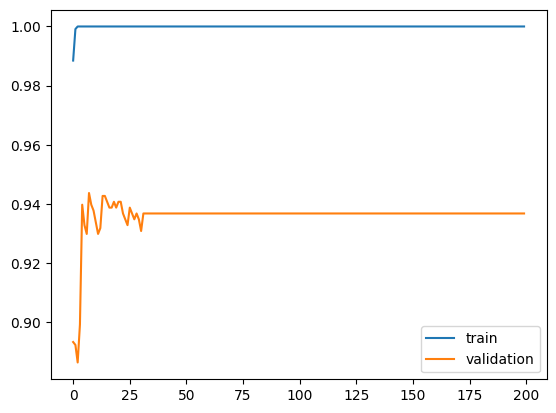

In [51]:
# Plot the learning curves
plt.plot(evals_result['train']['auc'], label='train')
plt.plot(evals_result['validation']['auc'], label='validation')
plt.legend()
plt.show()

In [52]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9367588932806324

## XGBoost Parameter Tuning


### Helper functions for parameter tuning

In [53]:
def tune_param(param_name: str, param_thresholds: list, xgb_params: dict):

    scores = {}
    thresholds = param_thresholds

    for thres in thresholds:

        # update the xgb_params
        xgb_params[param_name] = thres

        # create a key for the eta_scores
        param_key = f"{param_name}={thres}"

        # create a dictionary to store the output of the model
        evals_result = {}

        model = xgb.train(params=xgb_params,  # params defined above
                        dtrain=dtrain, 
                        num_boost_round=200, # total number of iterations
                        verbose_eval=10, # prints the progress of training every 10 training rounds
                        evals=watchlist, # monitor the metric for training and validation
                        evals_result = evals_result)

        # store the resutl eta_scores
        scores[param_key] = evals_result

    return scores

In [54]:
# potential bug is if you provide a threshold that was not used for training
def plot_param_metric(param_name: str, param_thresholds: list, evals_result: dict):
    for thres in param_thresholds:
        param_key = f"{param_name}={thres}"
        plt.plot(evals_result[param_key]['validation']['auc'], label=param_key)
        plt.legend()

In [55]:
def update_xgb_params(param_name: str, update_value: float, xgb_params):
    # update the xgb_params
    xgb_params[param_name] = update_value

    return xgb_params

### Tuning ETA

In [56]:
eta_scores = tune_param(param_name='eta', param_thresholds=[0.01, 0.05, 0.1, 0.3, 0.8, 1.0], xgb_params=xgb_params)

[0]	train-auc:0.98847	validation-auc:0.89328
[10]	train-auc:0.99846	validation-auc:0.87648
[20]	train-auc:0.99978	validation-auc:0.89625
[30]	train-auc:1.00000	validation-auc:0.89921
[40]	train-auc:1.00000	validation-auc:0.90316
[50]	train-auc:1.00000	validation-auc:0.90711
[60]	train-auc:1.00000	validation-auc:0.90415
[70]	train-auc:1.00000	validation-auc:0.90020
[80]	train-auc:1.00000	validation-auc:0.91700
[90]	train-auc:1.00000	validation-auc:0.93083
[100]	train-auc:1.00000	validation-auc:0.94071
[110]	train-auc:1.00000	validation-auc:0.94071
[120]	train-auc:1.00000	validation-auc:0.94664
[130]	train-auc:1.00000	validation-auc:0.94664
[140]	train-auc:1.00000	validation-auc:0.95059
[150]	train-auc:1.00000	validation-auc:0.95257
[160]	train-auc:1.00000	validation-auc:0.95652
[170]	train-auc:1.00000	validation-auc:0.95455
[180]	train-auc:1.00000	validation-auc:0.94862
[190]	train-auc:1.00000	validation-auc:0.95059
[199]	train-auc:1.00000	validation-auc:0.94664
[0]	train-auc:0.98847	va

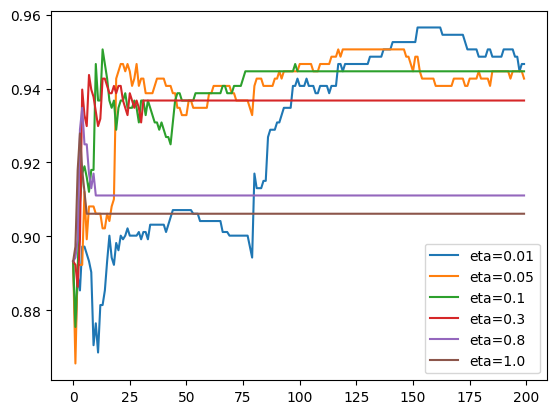

In [57]:
plot_param_metric('eta', [0.01, 0.05, 0.1, 0.3, 0.8, 1.0], eta_scores)

Based on the above graph the optimal learning rate appears to be eta=0.01. However, we also have to worry about overfitting to the training data. The safest option appears to be an eta=0.1. This will be the training rate that I use.

In [58]:
xgb_params=update_xgb_params('eta', 0.1, xgb_params)

### Tuning max_depth

In [59]:
depth_scores = tune_param(param_name='max_depth', param_thresholds=[3, 4, 6, 10, 15, 20], xgb_params=xgb_params)

[0]	train-auc:0.98847	validation-auc:0.89328
[10]	train-auc:1.00000	validation-auc:0.91897
[20]	train-auc:1.00000	validation-auc:0.94269
[30]	train-auc:1.00000	validation-auc:0.93874
[40]	train-auc:1.00000	validation-auc:0.93281
[50]	train-auc:1.00000	validation-auc:0.94071
[60]	train-auc:1.00000	validation-auc:0.94071
[70]	train-auc:1.00000	validation-auc:0.94466
[80]	train-auc:1.00000	validation-auc:0.95059
[90]	train-auc:1.00000	validation-auc:0.94664
[100]	train-auc:1.00000	validation-auc:0.94664
[110]	train-auc:1.00000	validation-auc:0.94664
[120]	train-auc:1.00000	validation-auc:0.94664
[130]	train-auc:1.00000	validation-auc:0.94664
[140]	train-auc:1.00000	validation-auc:0.94664
[150]	train-auc:1.00000	validation-auc:0.94664
[160]	train-auc:1.00000	validation-auc:0.94664
[170]	train-auc:1.00000	validation-auc:0.94664
[180]	train-auc:1.00000	validation-auc:0.94664
[190]	train-auc:1.00000	validation-auc:0.94664
[199]	train-auc:1.00000	validation-auc:0.94664
[0]	train-auc:0.98847	va

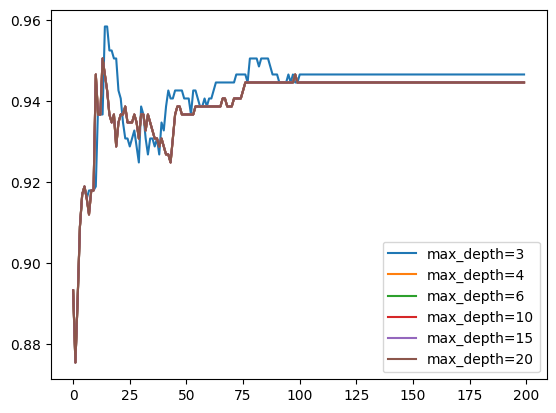

In [60]:
plot_param_metric(param_name='max_depth', param_thresholds=[3, 4, 6, 10, 15, 20], evals_result=depth_scores)

In [61]:
xgb_params=update_xgb_params('max_depth', 3, xgb_params)

### Tuning min_child_weight

In [62]:
min_child_weight_scores = tune_param(param_name='min_child_weight', param_thresholds=[1, 10, 30, 50, 80], xgb_params=xgb_params)

[0]	train-auc:0.98847	validation-auc:0.89328
[10]	train-auc:1.00000	validation-auc:0.91897
[20]	train-auc:1.00000	validation-auc:0.94269
[30]	train-auc:1.00000	validation-auc:0.93874
[40]	train-auc:1.00000	validation-auc:0.93281
[50]	train-auc:1.00000	validation-auc:0.94071
[60]	train-auc:1.00000	validation-auc:0.94071
[70]	train-auc:1.00000	validation-auc:0.94466
[80]	train-auc:1.00000	validation-auc:0.95059
[90]	train-auc:1.00000	validation-auc:0.94664
[100]	train-auc:1.00000	validation-auc:0.94664
[110]	train-auc:1.00000	validation-auc:0.94664
[120]	train-auc:1.00000	validation-auc:0.94664
[130]	train-auc:1.00000	validation-auc:0.94664
[140]	train-auc:1.00000	validation-auc:0.94664
[150]	train-auc:1.00000	validation-auc:0.94664
[160]	train-auc:1.00000	validation-auc:0.94664
[170]	train-auc:1.00000	validation-auc:0.94664
[180]	train-auc:1.00000	validation-auc:0.94664
[190]	train-auc:1.00000	validation-auc:0.94664
[199]	train-auc:1.00000	validation-auc:0.94664
[0]	train-auc:0.82773	va

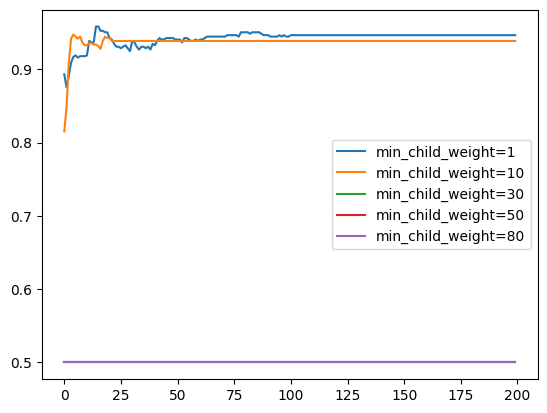

In [63]:
plot_param_metric(param_name='min_child_weight', param_thresholds=[1, 10, 30, 50, 80], evals_result=min_child_weight_scores)

Let's shrink the possible range of min_child_weight to between 1 and 10 and see which is the most optimal

In [64]:
min_child_weight_scores = tune_param(param_name='min_child_weight', param_thresholds=[1, 2, 4, 6, 8, 10], xgb_params=xgb_params)

[0]	train-auc:0.98847	validation-auc:0.89328
[10]	train-auc:1.00000	validation-auc:0.91897
[20]	train-auc:1.00000	validation-auc:0.94269
[30]	train-auc:1.00000	validation-auc:0.93874
[40]	train-auc:1.00000	validation-auc:0.93281
[50]	train-auc:1.00000	validation-auc:0.94071
[60]	train-auc:1.00000	validation-auc:0.94071
[70]	train-auc:1.00000	validation-auc:0.94466
[80]	train-auc:1.00000	validation-auc:0.95059
[90]	train-auc:1.00000	validation-auc:0.94664
[100]	train-auc:1.00000	validation-auc:0.94664
[110]	train-auc:1.00000	validation-auc:0.94664
[120]	train-auc:1.00000	validation-auc:0.94664
[130]	train-auc:1.00000	validation-auc:0.94664
[140]	train-auc:1.00000	validation-auc:0.94664
[150]	train-auc:1.00000	validation-auc:0.94664
[160]	train-auc:1.00000	validation-auc:0.94664
[170]	train-auc:1.00000	validation-auc:0.94664
[180]	train-auc:1.00000	validation-auc:0.94664
[190]	train-auc:1.00000	validation-auc:0.94664
[199]	train-auc:1.00000	validation-auc:0.94664
[0]	train-auc:0.97925	va

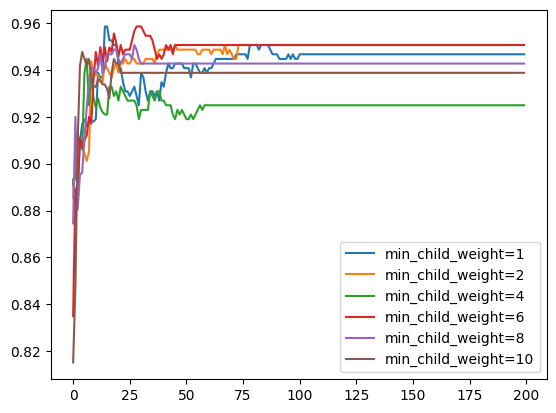

In [65]:
plot_param_metric(param_name='min_child_weight', param_thresholds=[1, 2, 4, 6, 8, 10], evals_result=min_child_weight_scores)

Based on the above result we choose a min_child_weight of 6.

In [66]:
final_params = update_xgb_params(param_name='min_child_weight', update_value=6, xgb_params=xgb_params)

In [67]:
# final xgboost model
model = xgb.train(xgb_params, dtrain, num_boost_round=175,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-auc:0.91831	validation-auc:0.83498
[5]	train-auc:0.99023	validation-auc:0.91008
[10]	train-auc:0.99517	validation-auc:0.94763
[15]	train-auc:0.99583	validation-auc:0.94368
[20]	train-auc:0.99671	validation-auc:0.94565
[25]	train-auc:0.99824	validation-auc:0.94862
[30]	train-auc:0.99868	validation-auc:0.95850
[35]	train-auc:0.99912	validation-auc:0.95257
[40]	train-auc:0.99912	validation-auc:0.94664
[45]	train-auc:0.99978	validation-auc:0.95059
[50]	train-auc:0.99978	validation-auc:0.95059
[55]	train-auc:0.99978	validation-auc:0.95059
[60]	train-auc:0.99978	validation-auc:0.95059
[65]	train-auc:0.99978	validation-auc:0.95059
[70]	train-auc:0.99978	validation-auc:0.95059
[75]	train-auc:0.99978	validation-auc:0.95059
[80]	train-auc:0.99978	validation-auc:0.95059
[85]	train-auc:0.99978	validation-auc:0.95059
[90]	train-auc:0.99978	validation-auc:0.95059
[95]	train-auc:0.99978	validation-auc:0.95059
[100]	train-auc:0.99978	validation-auc:0.95059
[105]	train-auc:0.99978	validation-

# Compare all of the models

In [68]:
# compute final model performance based on hyper parameter tuning for decision tree
dt = DecisionTreeClassifier(max_depth=1, min_samples_leaf=6, criterion='entropy', random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
dt_auc = roc_auc_score(y_val, y_pred)

# train final model with optimized hyperparameters for random forest
rf = RandomForestClassifier(n_estimators=30, max_depth=7, criterion='entropy', random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, y_pred)


# auc for xgboost
y_pred_xgb = model.predict(dval)
xgb_auc = roc_auc_score(y_val, y_pred_xgb)

print("DT auc: ", dt_auc)
print("Random Forest auc: ", rf_auc)
print("XGBoost auc", xgb_auc)

DT auc:  0.8547430830039525
Random Forest auc:  0.9219367588932806
XGBoost auc 0.9505928853754941


# Choose XGBoost as the Best Model

In [69]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.target).astype(int).values
del df_full_train['target']
del df_full_train['sample_source_name_ch1']

In [70]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [71]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=list(dv.get_feature_names_out()))

dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

In [72]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.9802371541501976

# Save the model

In [73]:
import pickle

In [77]:
version=1.0
eta, depth, min_child = final_params['eta'], final_params['max_depth'], final_params['min_child_weight']

output_file=f"xgb_model_eta={eta}_depth={depth}_min-child={min_child}_v{version}.bin"
output_file

'xgb_model_eta=0.1_depth=3_min-child=6_v1.0.bin'

In [ ]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

### Lastly, save a sample from training
- This sample will be used to see if the predict-test.py is working.

In [92]:
# get a training sample
sample = dicts_full_train[0]
sample

# convert to python datatype
sample_dtype_py = {k: int(v) for k, v in sample.items()}

# save to data
output_path = 'data/rna_sample.json'
with open(output_path, 'w') as f_out:
    json.dump(sample_dtype_py, f_out)

In [93]:
# get one more training sample
sample = dicts_full_train[1]
sample

# convert to python datatype
sample_dtype_py = {k: int(v) for k, v in sample.items()}

# save to data
output_path = 'data/rna_sample_1.json'
with open(output_path, 'w') as f_out:
    json.dump(sample_dtype_py, f_out)